<a href="https://colab.research.google.com/github/neuralcollapse/neuralcollapse/blob/main/neuralcollapse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Collapse Examples

Code demonstrating Neural Collapse on Cross-Entropy and MSE Loss.
Notebook is designed to be short, easy-to-interpret, and executable
from the browser using Google Colab.

MNIST-ResNet18 was chosen because it ran most reliably within the in-browser
memory constraints of Google Colab.
If you are *still* getting out-of-memory errors, try clicking
"Runtime"->"Factory Reset Runtime" on the menu bar.

It should be clear how to adapt the code to other networks-dataset combinations
to be run on local clusters with more memory.


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import gc
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models

from tqdm import tqdm
from collections import OrderedDict
from scipy.sparse.linalg import svds
from torchvision import datasets, transforms
from IPython import embed

debug = True # Only runs 20 batches per epoch for debugging

# dataset parameters
im_size             = 28
padded_im_size      = 32
C                   = 10
input_ch            = 1

# Optimization Criterion
# loss_name = 'CrossEntropyLoss'
loss_name = 'MSELoss'

# Optimization hyperparameters
lr_decay            = 0.1

# Best lr after hyperparameter tuning
if loss_name == 'CrossEntropyLoss':
  lr = 0.0679
elif loss_name == 'MSELoss':
  lr = 0.0184

epochs              = 350
epochs_lr_decay     = [epochs//3, epochs*2//3]

batch_size          = 128

momentum            = 0.9
weight_decay        = 5e-4

# analysis parameters
epoch_list          = [1,   2,   3,   4,   5,   6,   7,   8,   9,   10,   11,
                       12,  13,  14,  16,  17,  19,  20,  22,  24,  27,   29,
                       32,  35,  38,  42,  45,  50,  54,  59,  65,  71,   77,
                       85,  92,  101, 110, 121, 132, 144, 158, 172, 188,  206,
                       225, 245, 268, 293, 320, 350]

In [ ]:
def train(model, criterion, device, num_classes, train_loader, optimizer, epoch):
    model.train()
    
    pbar = tqdm(total=len(train_loader), position=0, leave=True)
    for batch_idx, (data, target) in enumerate(train_loader, start=1):
        if data.shape[0] != batch_size:
            continue
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        if str(criterion) == 'CrossEntropyLoss()':
          loss = criterion(out, target)
        elif str(criterion) == 'MSELoss()':
          loss = criterion(out, F.one_hot(target, num_classes=num_classes).float()) 
        
        loss.backward()
        optimizer.step()

        accuracy = torch.mean((torch.argmax(out,dim=1)==target).float()).item()

        pbar.update(1)
        pbar.set_description(
            'Train\t\tEpoch: {} [{}/{} ({:.0f}%)] \t'
            'Batch Loss: {:.6f} \t'
            'Batch Accuracy: {:.6f}'.format(
                epoch,
                batch_idx,
                len(train_loader),
                100. * batch_idx / len(train_loader),
                loss.item(),
                accuracy))
        
        if debug and batch_idx > 20:
          break
    pbar.close()

In [ ]:
def analysis(graphs, model, criterion_summed, device, num_classes, loader):
    model.eval()

    N             = [0 for _ in range(C)]
    mean          = [0 for _ in range(C)]
    Sw            = 0

    loss          = 0
    net_correct   = 0
    NCC_match_net = 0

    for computation in ['Mean','Cov']:
        pbar = tqdm(total=len(loader), position=0, leave=True)
        for batch_idx, (data, target) in enumerate(loader, start=1):

            data, target = data.to(device), target.to(device)

            output = model(data)
            h = features.value.data.view(data.shape[0],-1) # B CHW
            
            # during calculation of class means, calculate loss
            if computation == 'Mean':
                if str(criterion_summed) == 'CrossEntropyLoss()':
                  loss += criterion_summed(output, target).item()
                elif str(criterion_summed) == 'MSELoss()':
                  loss += criterion_summed(output, F.one_hot(target, num_classes=num_classes).float()).item()

            for c in range(C):
                # features belonging to class c
                idxs = (target == c).nonzero(as_tuple=True)[0]
                
                if len(idxs) == 0: # If no class-c in this batch
                  continue

                h_c = h[idxs,:] # B CHW

                if computation == 'Mean':
                    # update class means
                    mean[c] += torch.sum(h_c, dim=0) # CHW
                    N[c] += h_c.shape[0]
                    
                elif computation == 'Cov':
                    # update within-class cov

                    z = h_c - mean[c].unsqueeze(0) # B CHW
                    cov = torch.matmul(z.unsqueeze(-1), # B CHW 1
                                       z.unsqueeze(1))  # B 1 CHW
                    Sw += torch.sum(cov, dim=0)

                    # during calculation of within-class covariance, calculate:
                    # 1) network's accuracy
                    net_pred = torch.argmax(output[idxs,:], dim=1)
                    net_correct += sum(net_pred==target[idxs]).item()

                    # 2) agreement between prediction and nearest class center
                    NCC_scores = torch.stack([torch.norm(h_c[i,:] - M.T,dim=1) \
                                              for i in range(h_c.shape[0])])
                    NCC_pred = torch.argmin(NCC_scores, dim=1)
                    NCC_match_net += sum(NCC_pred==net_pred).item()

            pbar.update(1)
            pbar.set_description(
                'Analysis {}\t'
                'Epoch: {} [{}/{} ({:.0f}%)]'.format(
                    computation,
                    epoch,
                    batch_idx,
                    len(loader),
                    100. * batch_idx/ len(loader)))
            
            if debug and batch_idx > 20:
                break
        pbar.close()
        
        if computation == 'Mean':
            for c in range(C):
                mean[c] /= N[c]
                M = torch.stack(mean).T
            loss /= sum(N)
        elif computation == 'Cov':
            Sw /= sum(N)
    
    graphs.loss.append(loss)
    graphs.accuracy.append(net_correct/sum(N))
    graphs.NCC_mismatch.append(1-NCC_match_net/sum(N))

    # loss with weight decay
    reg_loss = loss
    for param in model.parameters():
        reg_loss += 0.5 * weight_decay * torch.sum(param**2).item()
    graphs.reg_loss.append(reg_loss)

    # global mean
    muG = torch.mean(M, dim=1, keepdim=True) # CHW 1
    
    # between-class covariance
    M_ = M - muG
    Sb = torch.matmul(M_, M_.T) / C

    # avg norm
    W  = classifier.weight
    M_norms = torch.norm(M_,  dim=0)
    W_norms = torch.norm(W.T, dim=0)

    graphs.norm_M_CoV.append((torch.std(M_norms)/torch.mean(M_norms)).item())
    graphs.norm_W_CoV.append((torch.std(W_norms)/torch.mean(W_norms)).item())

    # Decomposition of MSE #
    if loss_name == 'MSELoss':

      wd = 0.5 * weight_decay # "\lambda" in manuscript, so this is halved
      St = Sw+Sb
      size_last_layer = Sb.shape[0]
      eye_P = torch.eye(size_last_layer).to(device)
      eye_C = torch.eye(C).to(device)

      St_inv = torch.inverse(St + (wd/(wd+1))*(muG @ muG.T) + wd*eye_P)

      w_LS = 1 / C * (M.T - 1 / (1 + wd) * muG.T) @ St_inv
      b_LS = (1/C * torch.ones(C).to(device) - w_LS @ muG.T.squeeze(0)) / (1+wd)
      w_LS_ = torch.cat([w_LS, b_LS.unsqueeze(-1)], dim=1)  # c x n
      b  = classifier.bias
      w_ = torch.cat([W, b.unsqueeze(-1)], dim=1)  # c x n

      LNC1 = 0.5 * (torch.trace(w_LS @ (Sw + wd*eye_P) @ w_LS.T) + wd*torch.norm(b_LS)**2)
      LNC23 = 0.5/C * torch.norm(w_LS @ M + b_LS.unsqueeze(1) - eye_C) ** 2

      A1 = torch.cat([St + muG @ muG.T + wd*eye_P, muG], dim=1)
      A2 = torch.cat([muG.T, torch.ones([1,1]).to(device) + wd], dim=1)
      A = torch.cat([A1, A2], dim=0)
      Lperp = 0.5 * torch.trace((w_ - w_LS_) @ A @ (w_ - w_LS_).T)

      MSE_wd_features = loss + 0.5* weight_decay * (torch.norm(W)**2 + torch.norm(b)**2).item()
      MSE_wd_features *= 0.5

      graphs.MSE_wd_features.append(MSE_wd_features)
      graphs.LNC1.append(LNC1.item())
      graphs.LNC23.append(LNC23.item())
      graphs.Lperp.append(Lperp.item())

    # tr{Sw Sb^-1}
    Sw = Sw.cpu().numpy()
    Sb = Sb.cpu().numpy()
    eigvec, eigval, _ = svds(Sb, k=C-1)
    inv_Sb = eigvec @ np.diag(eigval**(-1)) @ eigvec.T 
    graphs.Sw_invSb.append(np.trace(Sw @ inv_Sb))

    # ||W^T - M_||
    normalized_M = M_ / torch.norm(M_,'fro')
    normalized_W = W.T / torch.norm(W.T,'fro')
    graphs.W_M_dist.append((torch.norm(normalized_W - normalized_M)**2).item())

    # mutual coherence
    def coherence(V): 
        G = V.T @ V
        G += torch.ones((C,C),device=device) / (C-1)
        G -= torch.diag(torch.diag(G))
        return torch.norm(G,1).item() / (C*(C-1))

    graphs.cos_M.append(coherence(M_/M_norms))
    graphs.cos_W.append(coherence(W.T/W_norms))

Train		Epoch: 1 [21/469 (4%)] 	Batch Loss: 0.101459 	Batch Accuracy: 0.468750:   4%|▍         | 21/469 [00:03<01:17,  5.75it/s]
Analysis Cov	Epoch: 1 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:28, 15.67it/s]


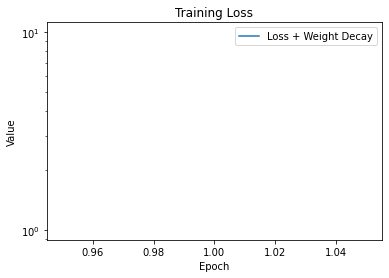

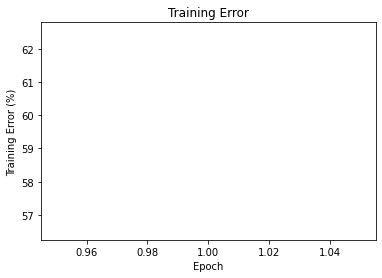

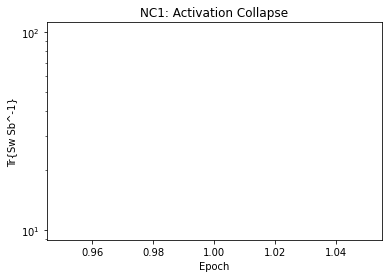

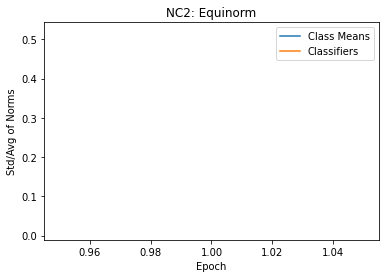

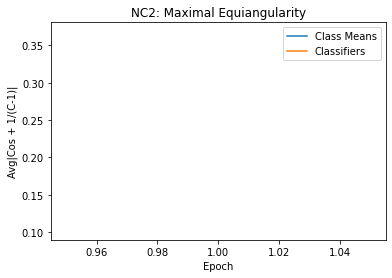

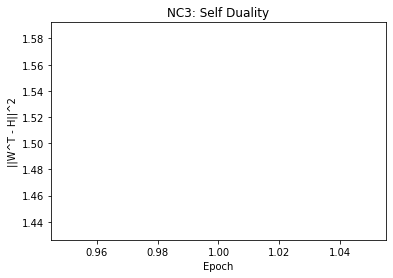

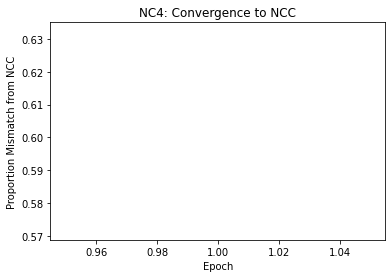

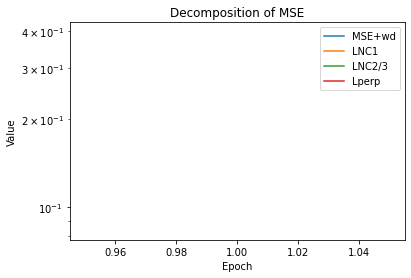

Train		Epoch: 2 [21/469 (4%)] 	Batch Loss: 0.056915 	Batch Accuracy: 0.757812:   4%|▍         | 21/469 [00:03<01:18,  5.71it/s]
Analysis Cov	Epoch: 2 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:29, 14.95it/s]


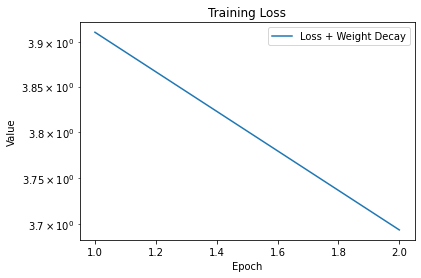

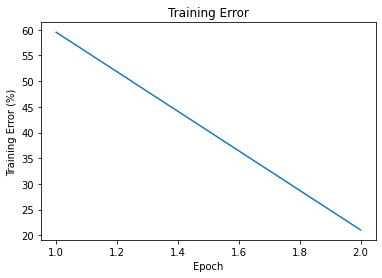

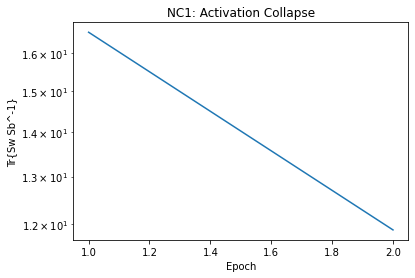

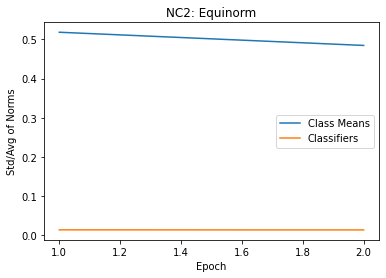

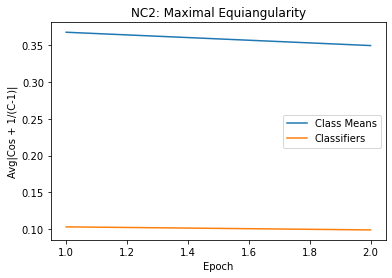

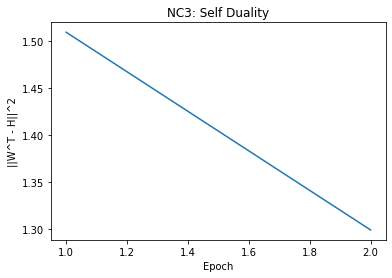

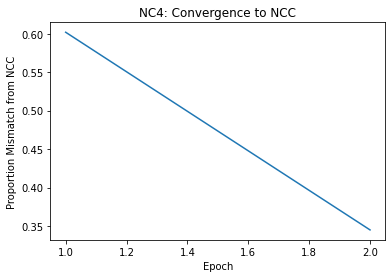

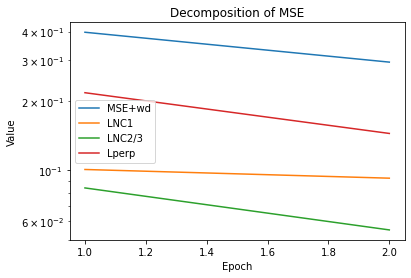

Train		Epoch: 3 [21/469 (4%)] 	Batch Loss: 0.045878 	Batch Accuracy: 0.835938:   4%|▍         | 21/469 [00:03<01:19,  5.60it/s]
Analysis Cov	Epoch: 3 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:30, 14.73it/s]


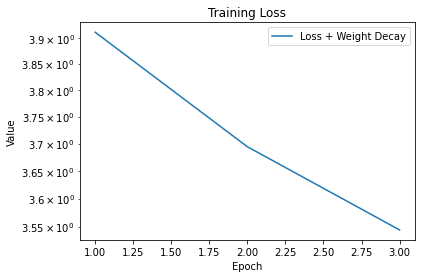

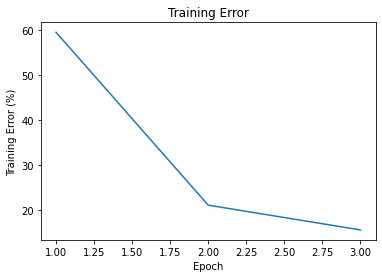

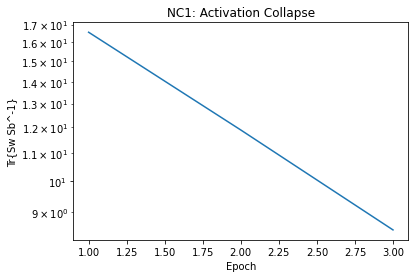

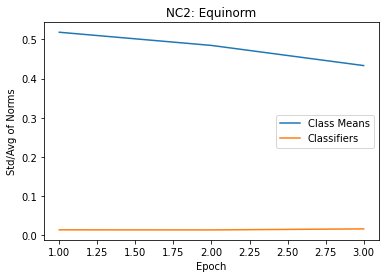

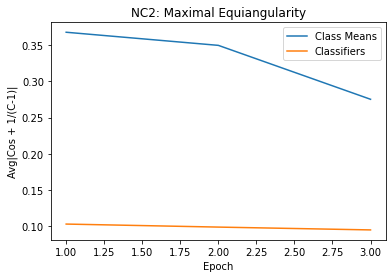

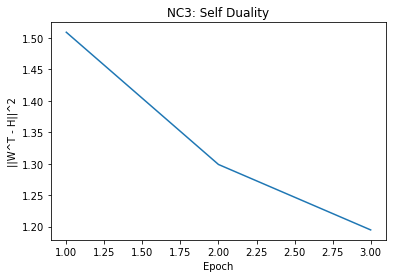

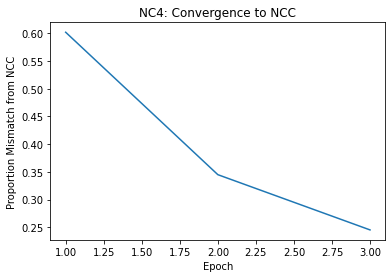

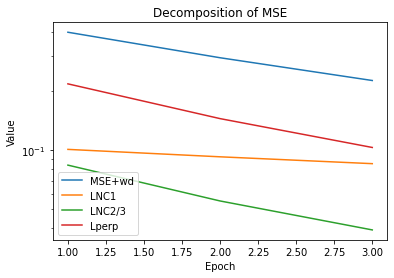

Train		Epoch: 4 [21/469 (4%)] 	Batch Loss: 0.034990 	Batch Accuracy: 0.921875:   4%|▍         | 21/469 [00:03<01:19,  5.65it/s]
Analysis Cov	Epoch: 4 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:31, 14.32it/s]


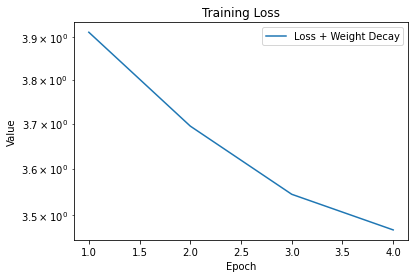

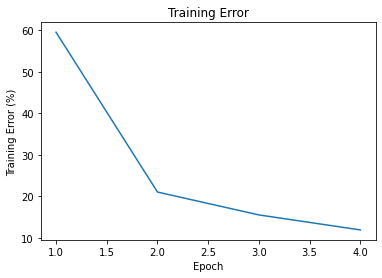

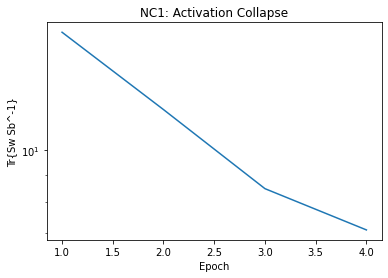

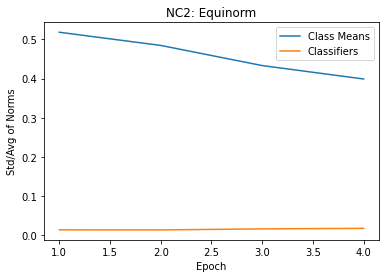

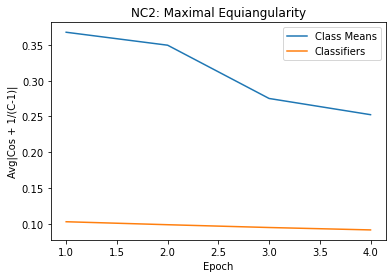

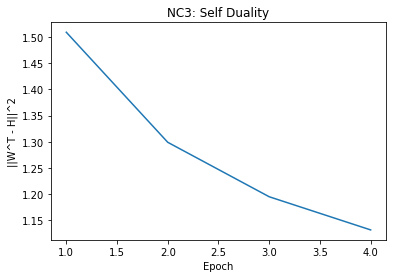

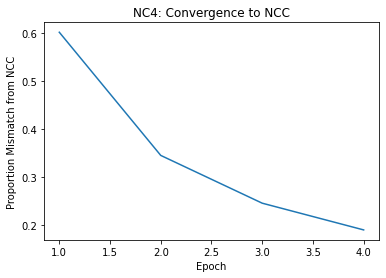

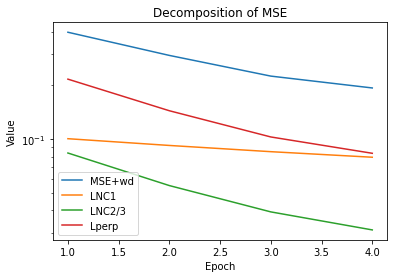

Train		Epoch: 5 [21/469 (4%)] 	Batch Loss: 0.030267 	Batch Accuracy: 0.937500:   4%|▍         | 21/469 [00:03<01:21,  5.47it/s]
Analysis Cov	Epoch: 5 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:31, 14.17it/s]


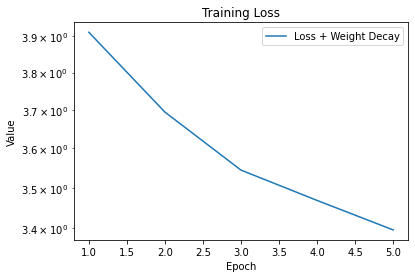

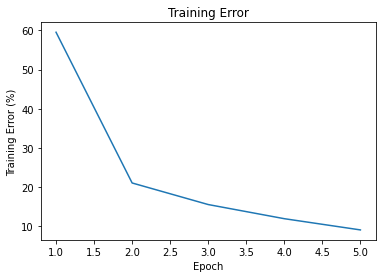

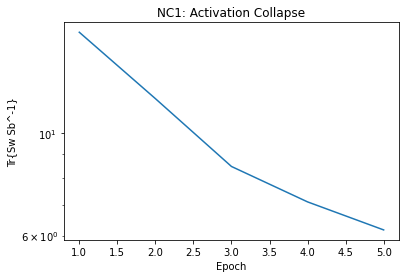

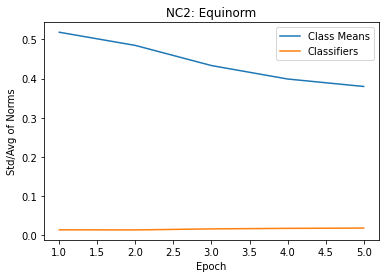

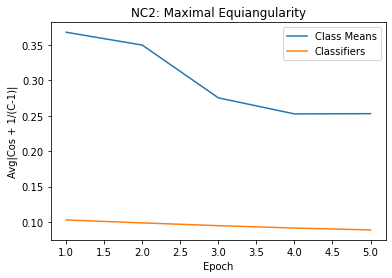

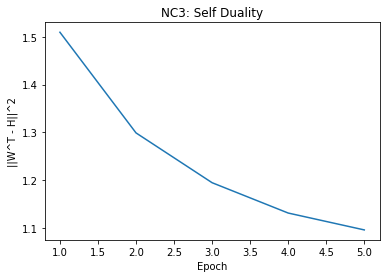

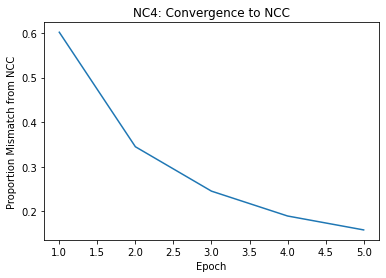

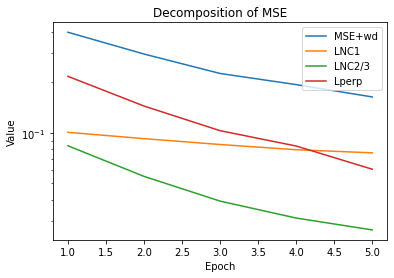

Train		Epoch: 6 [21/469 (4%)] 	Batch Loss: 0.033429 	Batch Accuracy: 0.890625:   4%|▍         | 21/469 [00:03<01:23,  5.38it/s]
Analysis Cov	Epoch: 6 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:33, 13.47it/s]


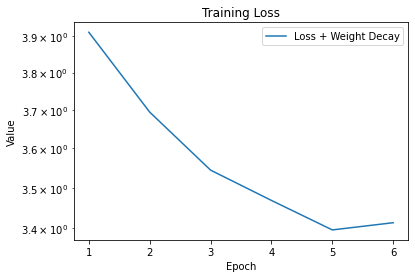

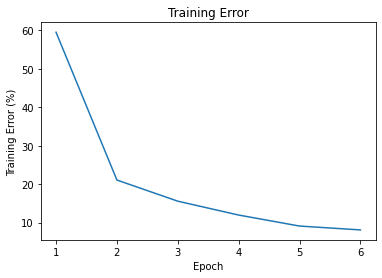

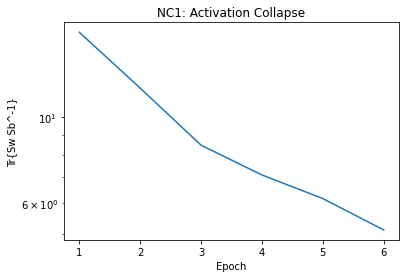

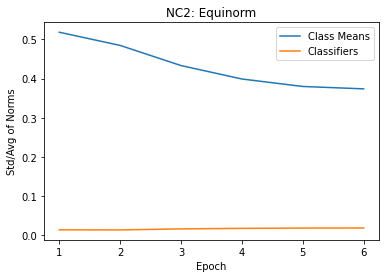

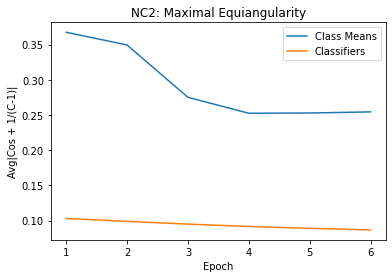

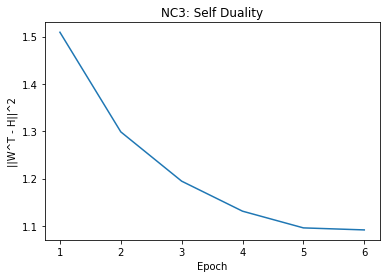

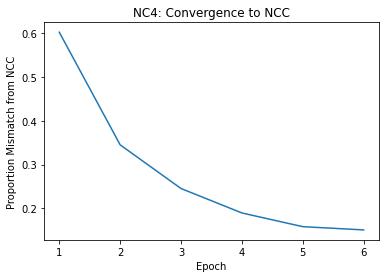

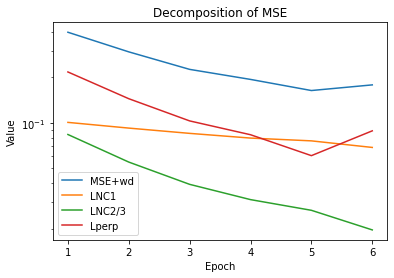

Train		Epoch: 7 [21/469 (4%)] 	Batch Loss: 0.032059 	Batch Accuracy: 0.937500:   4%|▍         | 21/469 [00:03<01:22,  5.44it/s]
Analysis Cov	Epoch: 7 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:32, 13.72it/s]


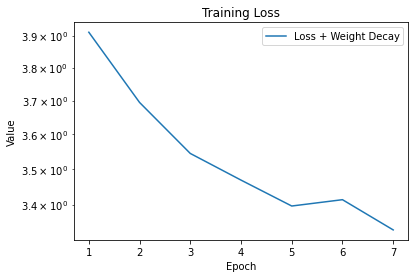

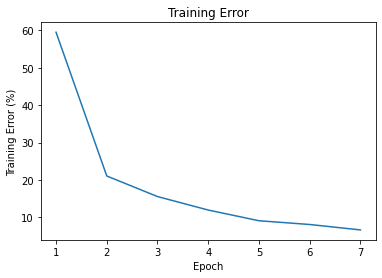

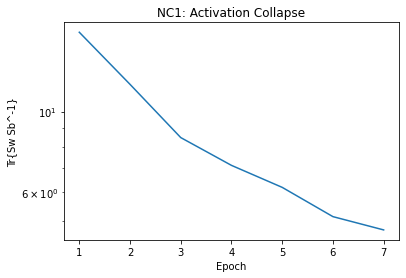

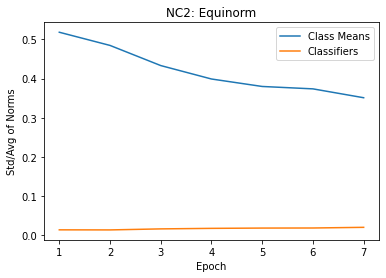

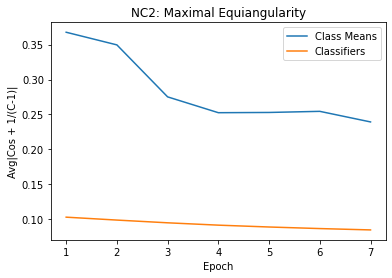

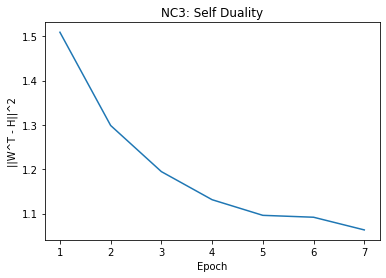

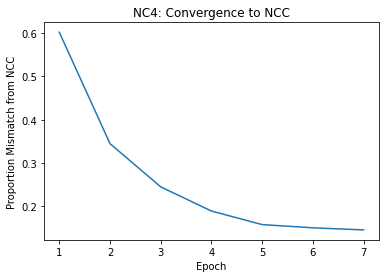

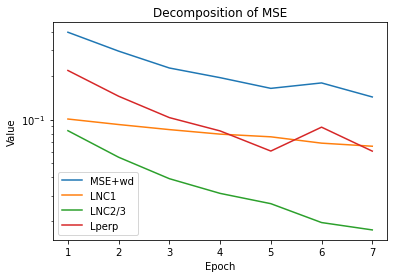

Train		Epoch: 8 [21/469 (4%)] 	Batch Loss: 0.030112 	Batch Accuracy: 0.906250:   4%|▍         | 21/469 [00:03<01:24,  5.31it/s]
Analysis Cov	Epoch: 8 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:34, 13.05it/s]


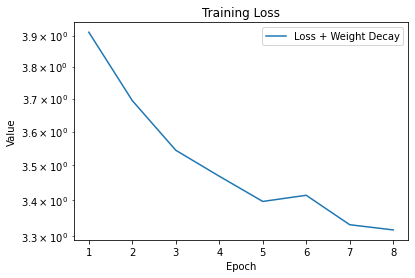

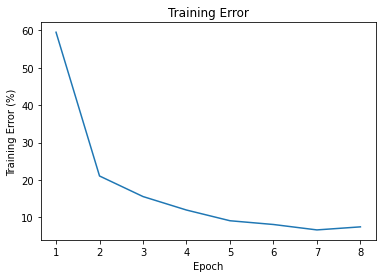

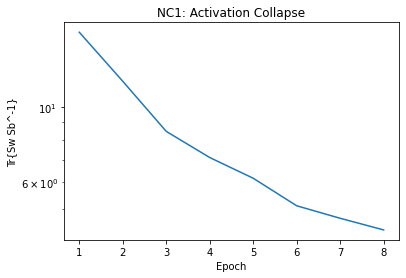

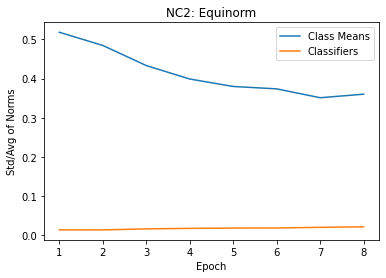

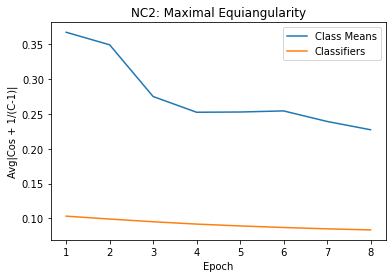

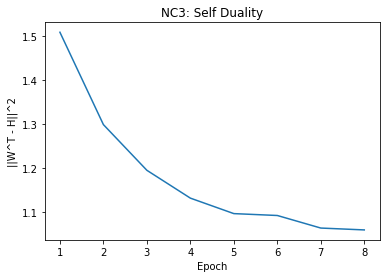

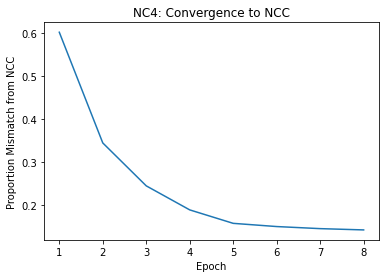

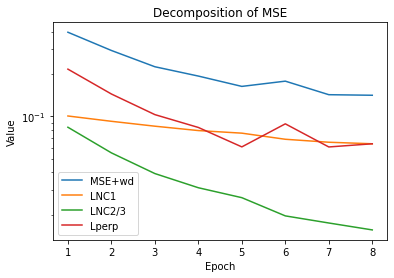

Train		Epoch: 9 [21/469 (4%)] 	Batch Loss: 0.023060 	Batch Accuracy: 0.968750:   4%|▍         | 21/469 [00:04<01:27,  5.11it/s]
Analysis Cov	Epoch: 9 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:34, 12.93it/s]


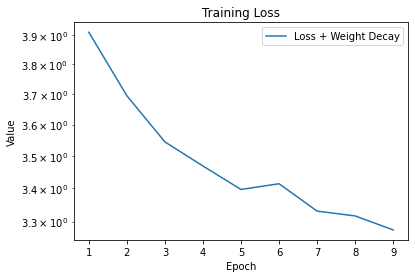

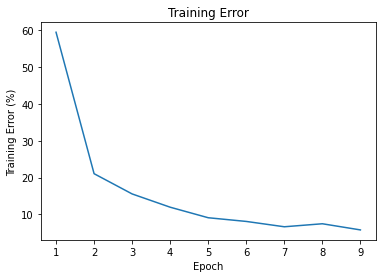

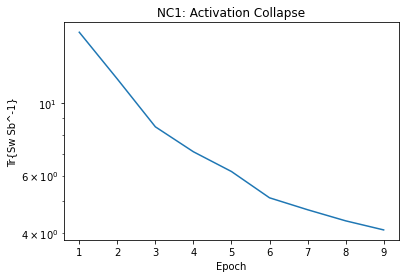

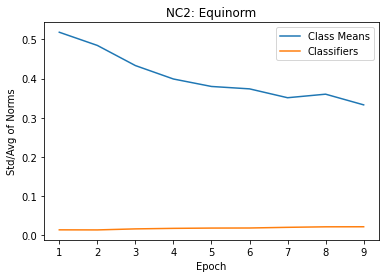

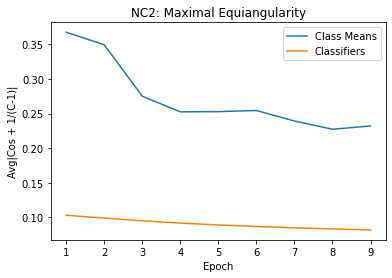

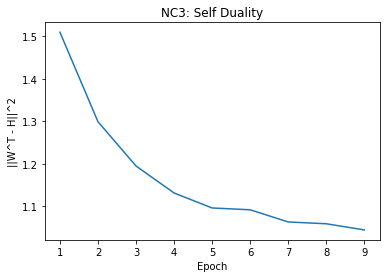

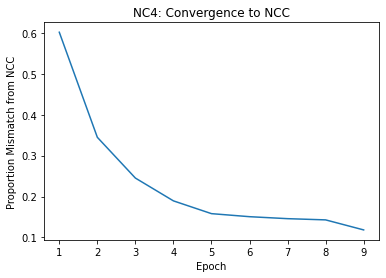

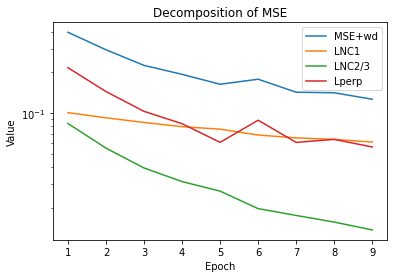

Train		Epoch: 10 [21/469 (4%)] 	Batch Loss: 0.028539 	Batch Accuracy: 0.960938:   4%|▍         | 21/469 [00:04<01:28,  5.08it/s]
Analysis Cov	Epoch: 10 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:34, 13.01it/s]


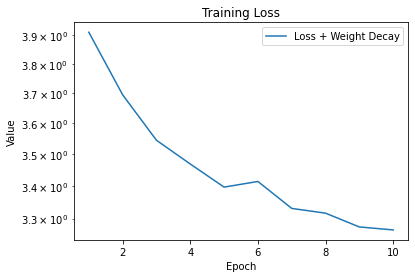

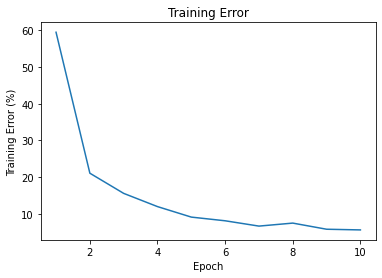

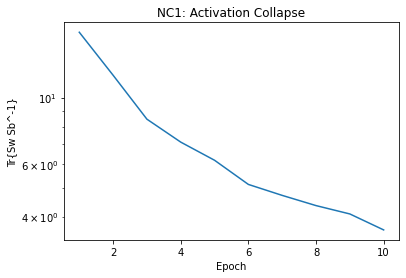

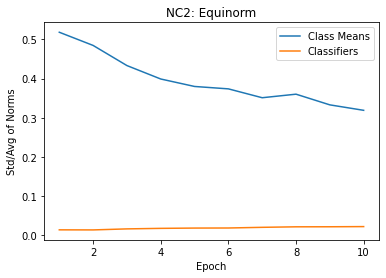

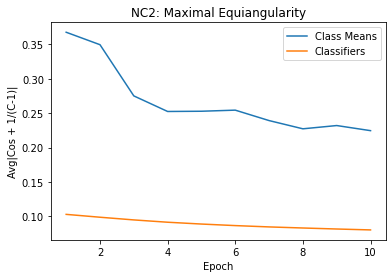

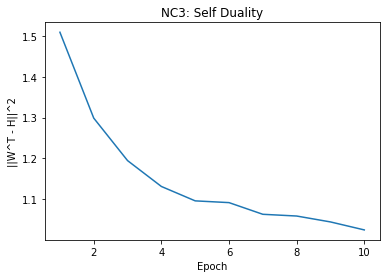

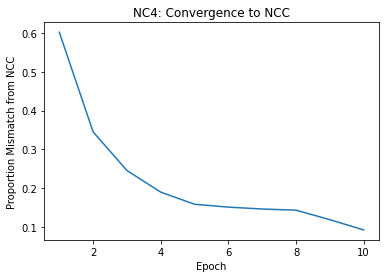

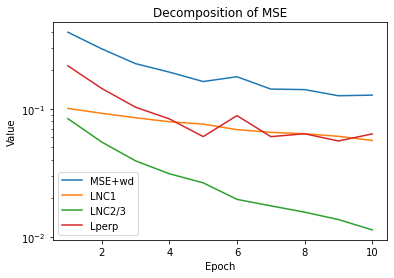

Train		Epoch: 11 [21/469 (4%)] 	Batch Loss: 0.019942 	Batch Accuracy: 0.937500:   4%|▍         | 21/469 [00:04<01:29,  5.01it/s]
Analysis Cov	Epoch: 11 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:36, 12.33it/s]


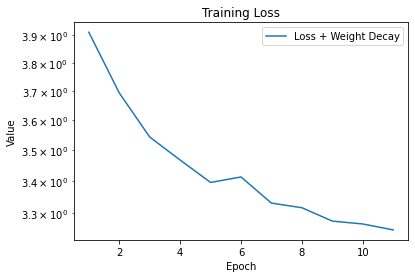

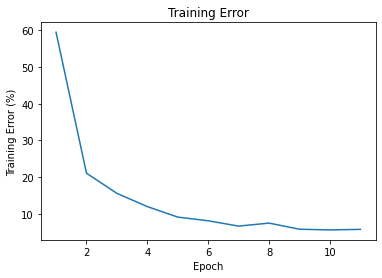

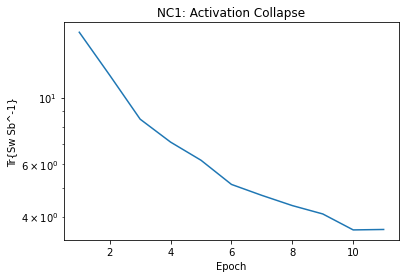

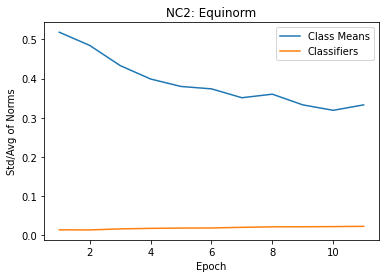

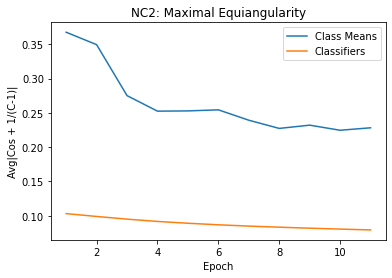

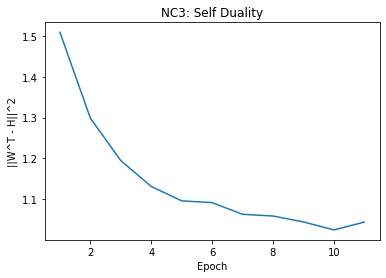

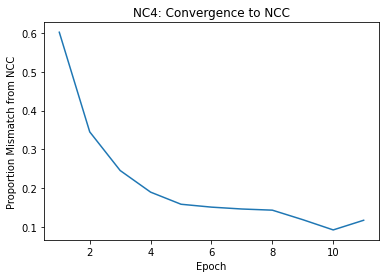

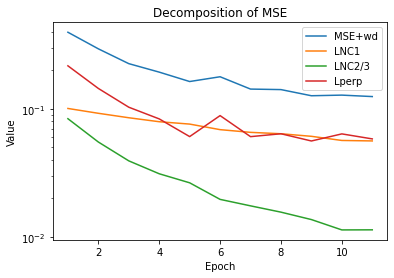

Train		Epoch: 12 [21/469 (4%)] 	Batch Loss: 0.019473 	Batch Accuracy: 0.968750:   4%|▍         | 21/469 [00:04<01:31,  4.91it/s]
Analysis Cov	Epoch: 12 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:35, 12.78it/s]


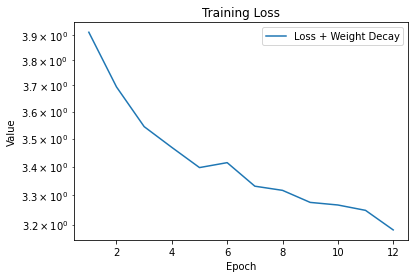

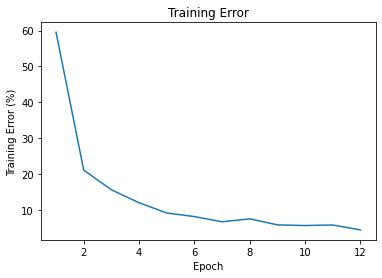

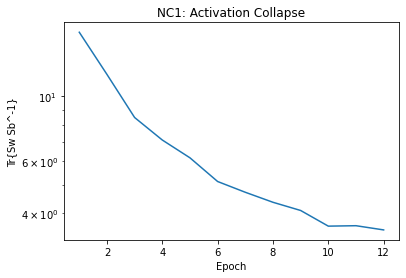

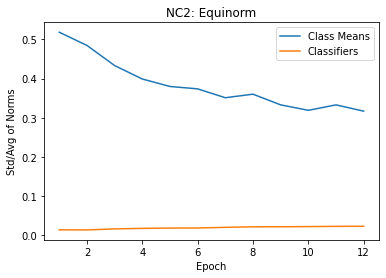

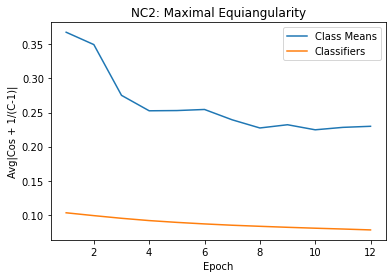

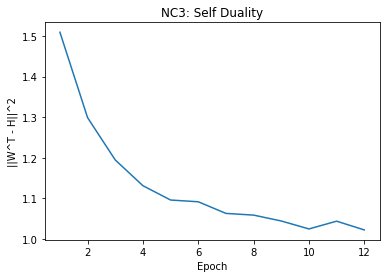

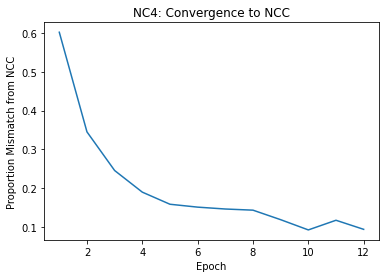

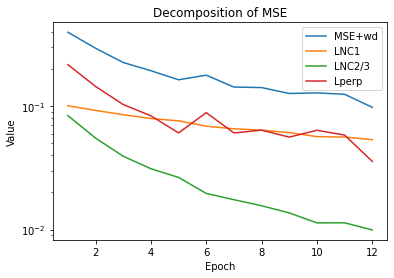

Train		Epoch: 13 [21/469 (4%)] 	Batch Loss: 0.023746 	Batch Accuracy: 0.914062:   4%|▍         | 21/469 [00:04<01:30,  4.94it/s]
Analysis Cov	Epoch: 13 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:35, 12.61it/s]


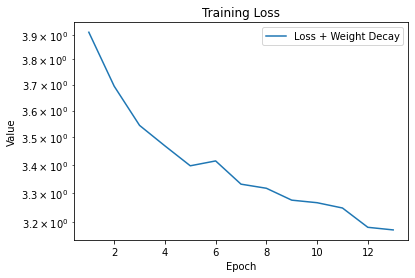

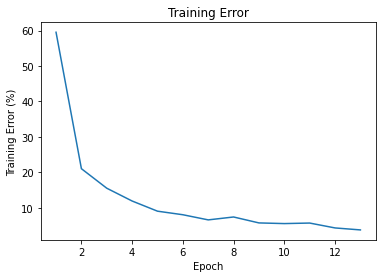

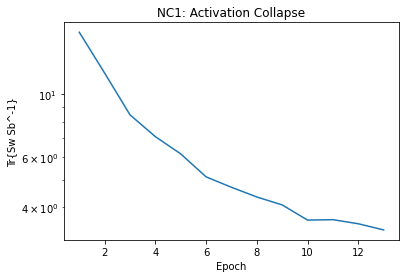

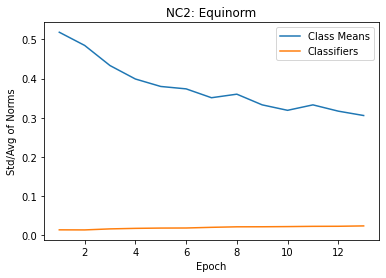

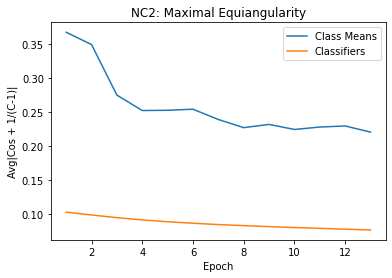

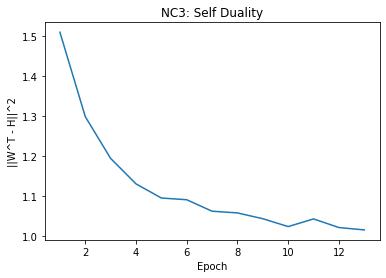

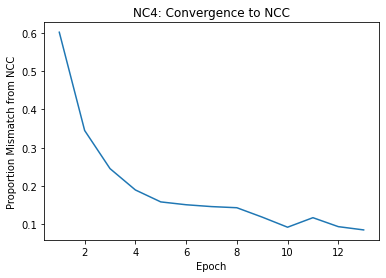

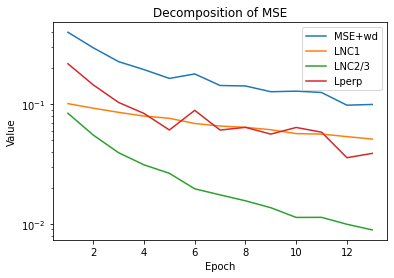

Train		Epoch: 14 [21/469 (4%)] 	Batch Loss: 0.022838 	Batch Accuracy: 0.945312:   4%|▍         | 21/469 [00:04<01:30,  4.95it/s]
Analysis Cov	Epoch: 14 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:35, 12.64it/s]


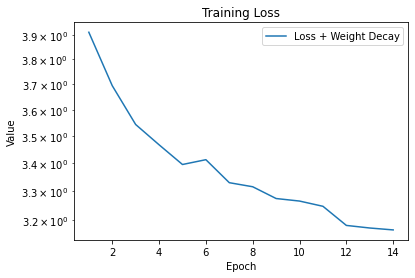

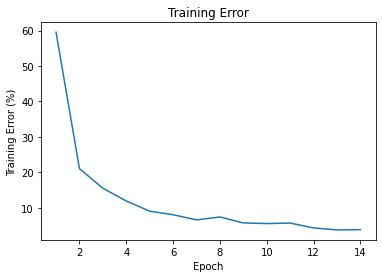

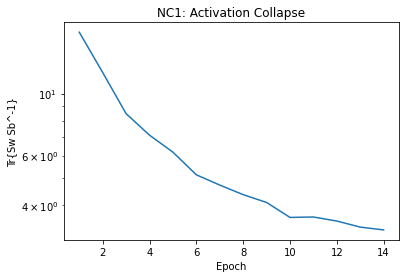

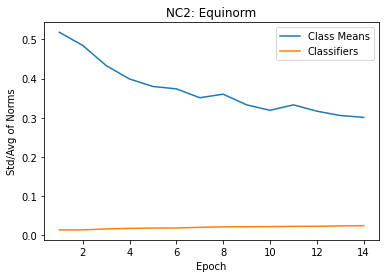

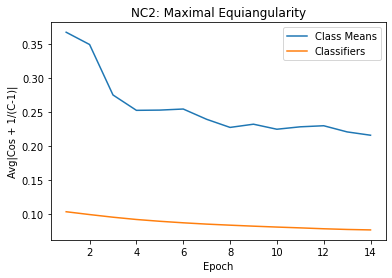

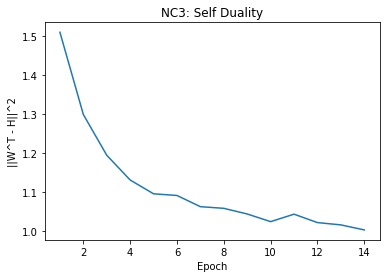

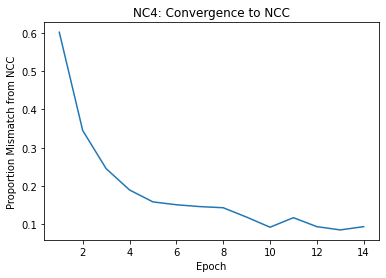

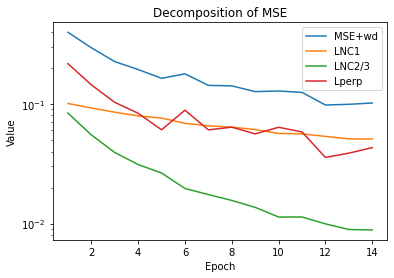

Train		Epoch: 15 [21/469 (4%)] 	Batch Loss: 0.024945 	Batch Accuracy: 0.937500:   4%|▍         | 21/469 [00:04<01:31,  4.92it/s]
Train		Epoch: 16 [21/469 (4%)] 	Batch Loss: 0.019076 	Batch Accuracy: 0.937500:   4%|▍         | 21/469 [00:04<01:30,  4.97it/s]
Analysis Cov	Epoch: 16 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:35, 12.55it/s]


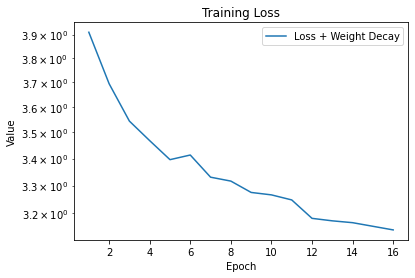

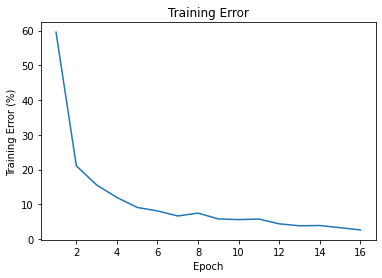

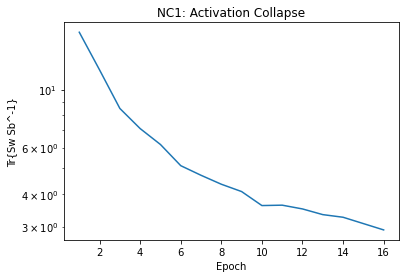

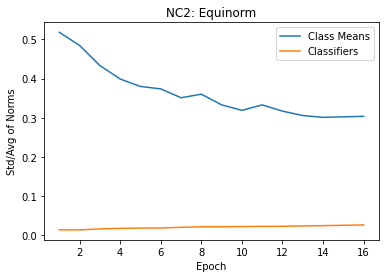

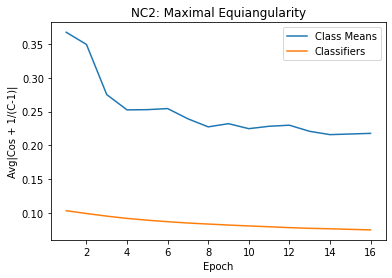

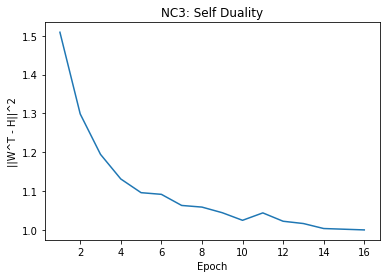

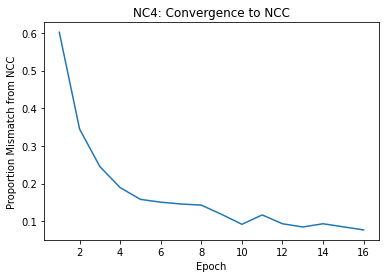

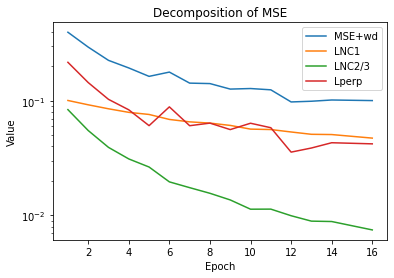

Train		Epoch: 17 [21/469 (4%)] 	Batch Loss: 0.022501 	Batch Accuracy: 0.945312:   4%|▍         | 21/469 [00:04<01:28,  5.06it/s]
Analysis Cov	Epoch: 17 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:37, 11.92it/s]


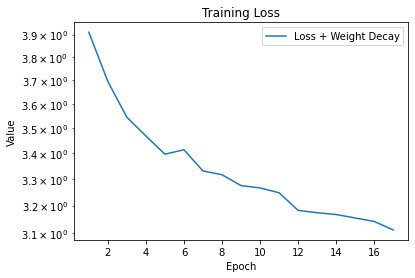

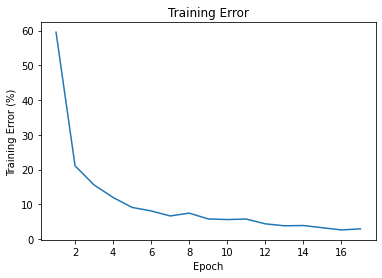

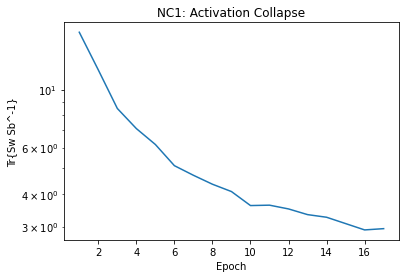

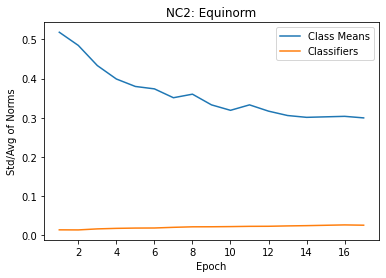

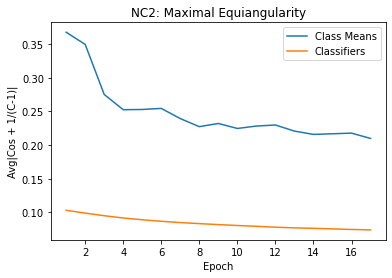

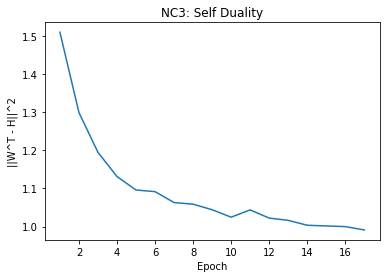

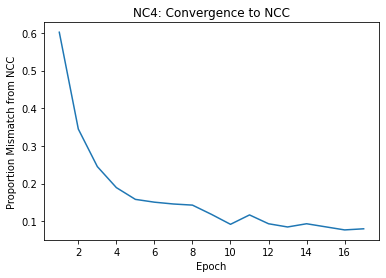

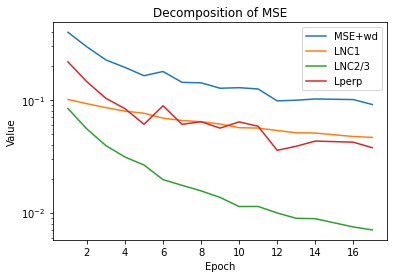

Train		Epoch: 18 [21/469 (4%)] 	Batch Loss: 0.020598 	Batch Accuracy: 0.960938:   4%|▍         | 21/469 [00:04<01:28,  5.05it/s]
Train		Epoch: 19 [21/469 (4%)] 	Batch Loss: 0.017300 	Batch Accuracy: 0.960938:   4%|▍         | 21/469 [00:04<01:27,  5.12it/s]
Analysis Cov	Epoch: 19 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:38, 11.76it/s]


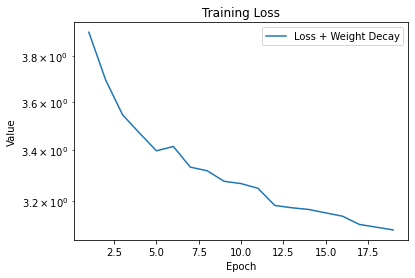

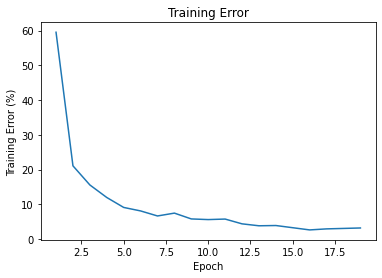

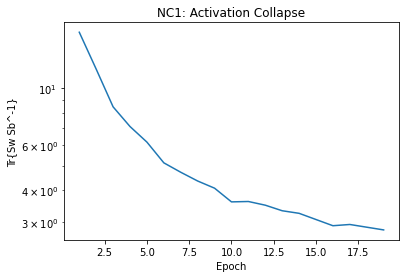

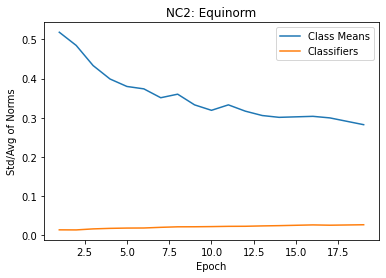

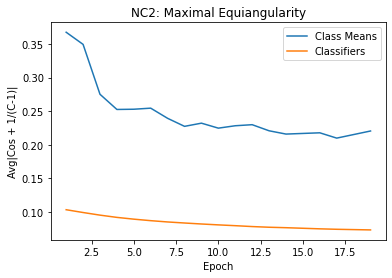

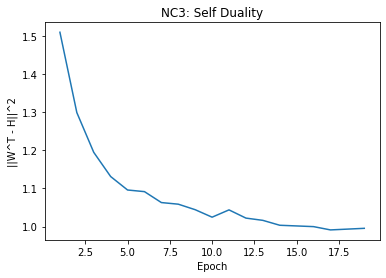

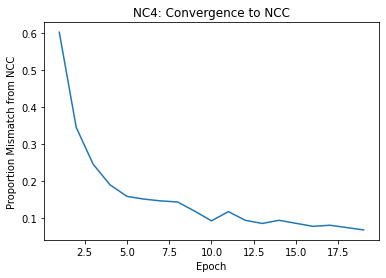

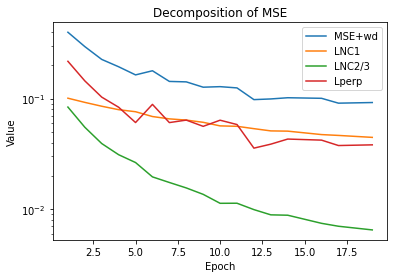

Train		Epoch: 20 [21/469 (4%)] 	Batch Loss: 0.017506 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:04<01:29,  5.02it/s]
Analysis Cov	Epoch: 20 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:38, 11.66it/s]


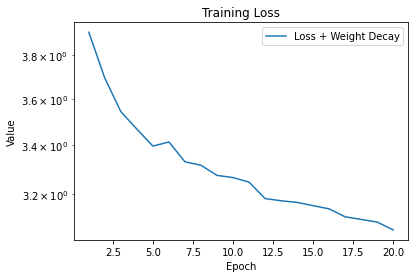

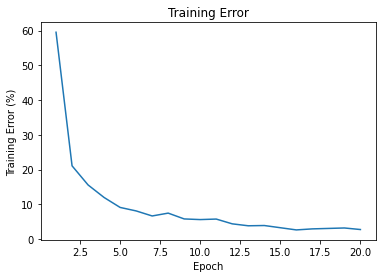

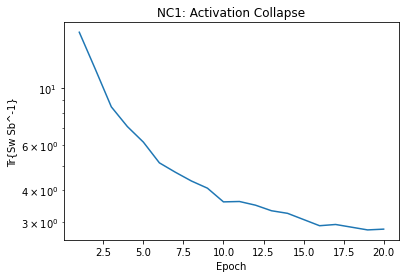

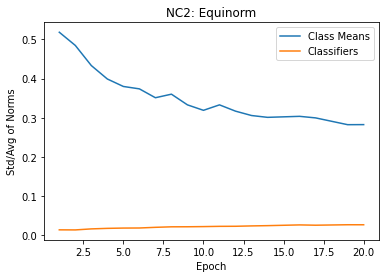

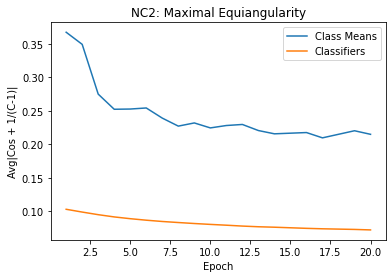

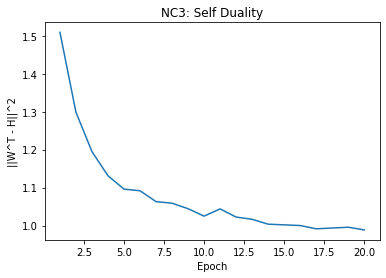

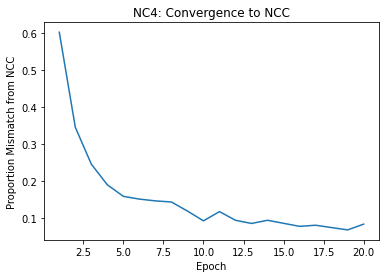

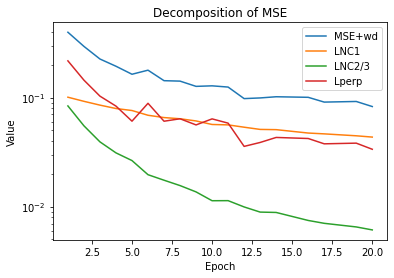

Train		Epoch: 21 [21/469 (4%)] 	Batch Loss: 0.019699 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:04<01:29,  4.99it/s]
Train		Epoch: 22 [21/469 (4%)] 	Batch Loss: 0.017335 	Batch Accuracy: 0.976562:   4%|▍         | 21/469 [00:04<01:31,  4.91it/s]
Analysis Cov	Epoch: 22 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:38, 11.58it/s]


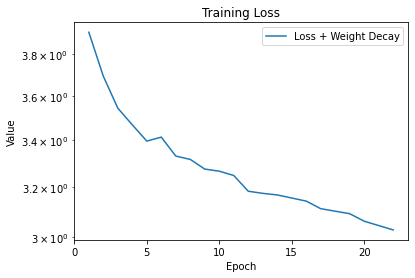

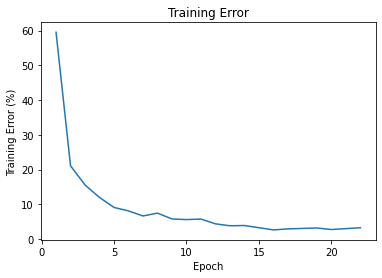

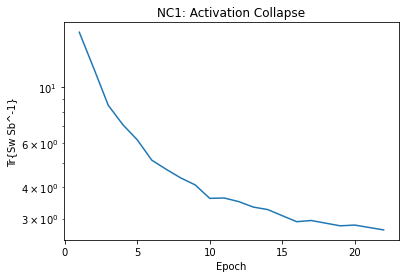

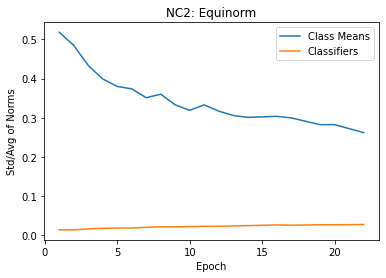

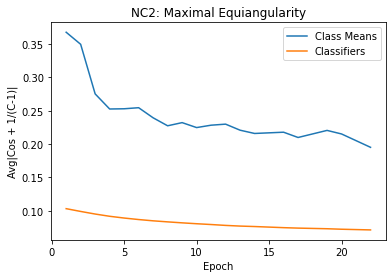

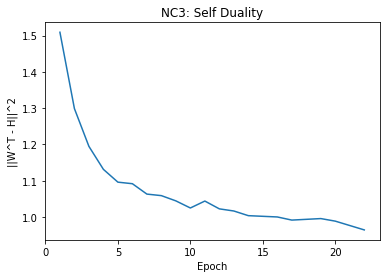

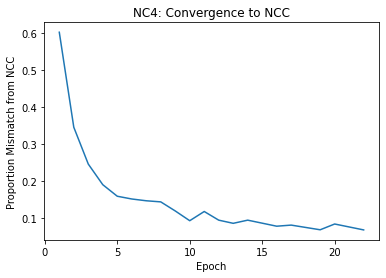

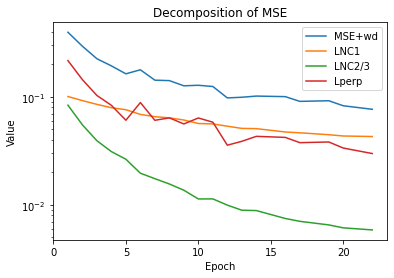

Train		Epoch: 23 [21/469 (4%)] 	Batch Loss: 0.020763 	Batch Accuracy: 0.984375:   4%|▍         | 21/469 [00:04<01:29,  4.99it/s]
Train		Epoch: 24 [21/469 (4%)] 	Batch Loss: 0.022296 	Batch Accuracy: 0.968750:   4%|▍         | 21/469 [00:04<01:28,  5.03it/s]
Analysis Cov	Epoch: 24 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:38, 11.74it/s]


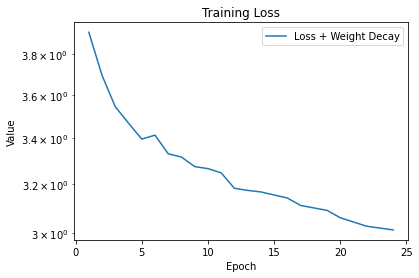

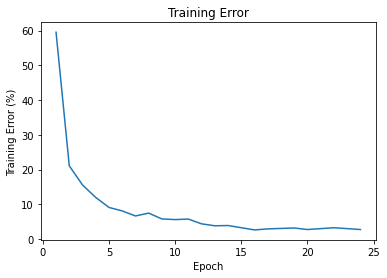

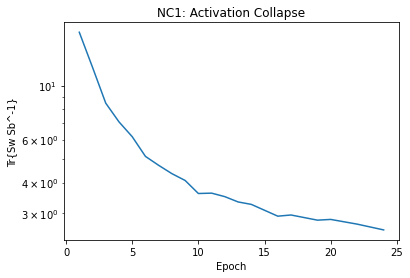

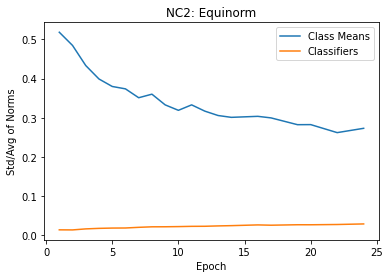

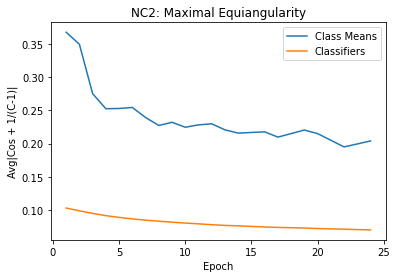

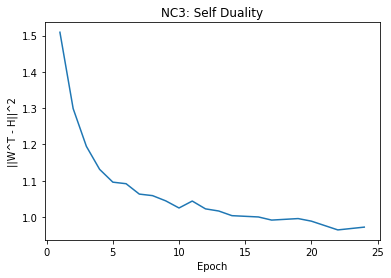

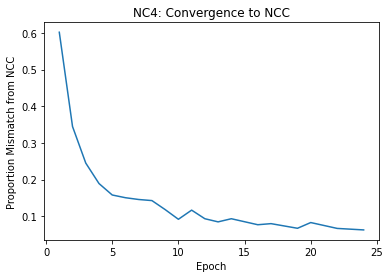

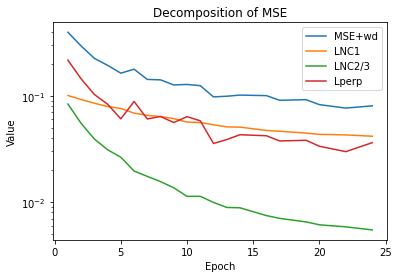

Train		Epoch: 25 [21/469 (4%)] 	Batch Loss: 0.017736 	Batch Accuracy: 0.953125:   4%|▍         | 21/469 [00:04<01:31,  4.91it/s]
Train		Epoch: 26 [21/469 (4%)] 	Batch Loss: 0.020640 	Batch Accuracy: 0.945312:   4%|▍         | 21/469 [00:04<01:28,  5.04it/s]
Train		Epoch: 27 [21/469 (4%)] 	Batch Loss: 0.012699 	Batch Accuracy: 0.968750:   4%|▍         | 21/469 [00:04<01:28,  5.07it/s]
Analysis Cov	Epoch: 27 [21/469 (4%)]:   4%|▍         | 21/469 [00:01<00:37, 12.07it/s]


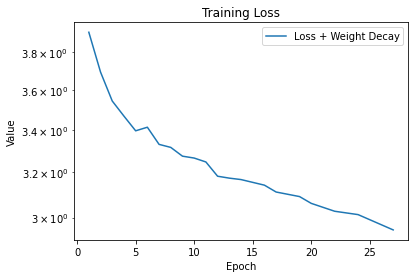

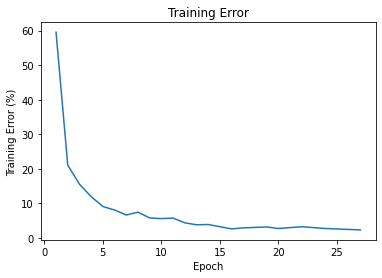

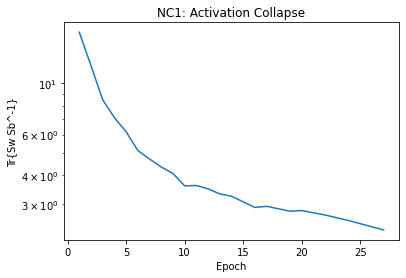

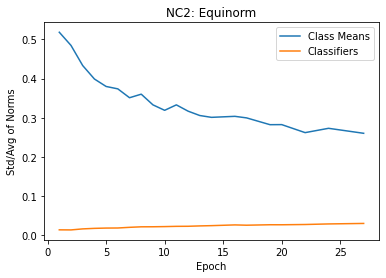

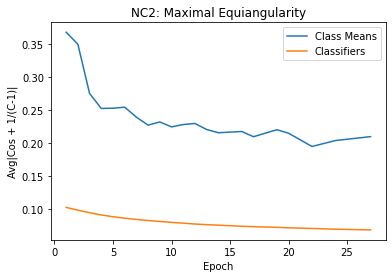

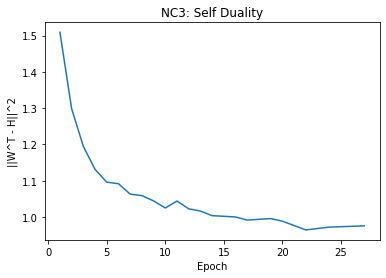

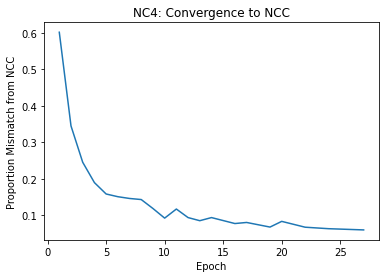

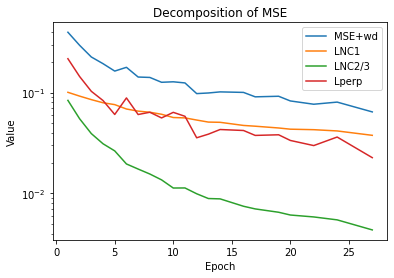

Train		Epoch: 28 [21/469 (4%)] 	Batch Loss: 0.015393 	Batch Accuracy: 0.976562:   4%|▍         | 21/469 [00:04<01:32,  4.86it/s]
Train		Epoch: 29 [21/469 (4%)] 	Batch Loss: 0.012175 	Batch Accuracy: 0.992188:   4%|▍         | 21/469 [00:04<01:29,  4.98it/s]
Analysis Cov	Epoch: 29 [21/469 (4%)]:   4%|▍         | 21/469 [00:02<00:43, 10.39it/s]


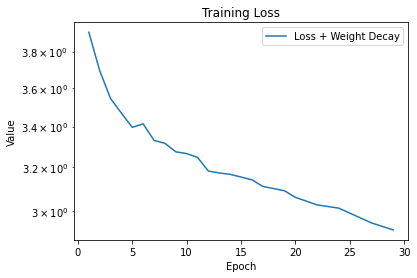

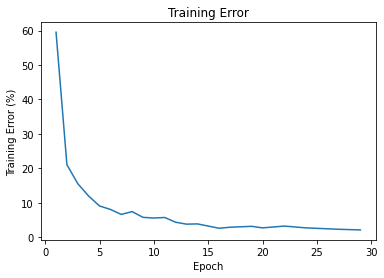

In [ ]:
model = models.resnet18(pretrained=False, num_classes=C)
model.conv1 = nn.Conv2d(input_ch, model.conv1.weight.shape[0], 3, 1, 1, bias=False) # Small dataset filter size used by He et al. (2015)
model.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0)
model = model.to(device)

class features:
    pass

def hook(self, input, output):
    features.value = input[0].clone()

# register hook that saves last-layer input into features
classifier = model.fc
classifier.register_forward_hook(hook)

transform = transforms.Compose([transforms.Pad((padded_im_size - im_size)//2),
                                transforms.ToTensor(),
                                transforms.Normalize(0.1307,0.3081)])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

analysis_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

if loss_name == 'CrossEntropyLoss':
  criterion = nn.CrossEntropyLoss()
  criterion_summed = nn.CrossEntropyLoss(reduction='sum')
elif loss_name == 'MSELoss':
  criterion = nn.MSELoss()
  criterion_summed = nn.MSELoss(reduction='sum')

optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                              milestones=epochs_lr_decay,
                                              gamma=lr_decay)

class graphs:
  def __init__(self):
    self.accuracy     = []
    self.loss         = []
    self.reg_loss     = []

    # NC1
    self.Sw_invSb     = []

    # NC2
    self.norm_M_CoV   = []
    self.norm_W_CoV   = []
    self.cos_M        = []
    self.cos_W        = []

    # NC3
    self.W_M_dist     = []
    
    # NC4
    self.NCC_mismatch = []

    # Decomposition
    self.MSE_wd_features = []
    self.LNC1 = []
    self.LNC23 = []
    self.Lperp = []
graphs = graphs()

cur_epochs = []
for epoch in range(1, epochs + 1):
    train(model, criterion, device, C, train_loader, optimizer, epoch)
    lr_scheduler.step()
    
    if epoch in epoch_list:
        cur_epochs.append(epoch)
        analysis(graphs, model, criterion_summed, device, C, analysis_loader)
        
        plt.figure(1)
        plt.semilogy(cur_epochs, graphs.reg_loss)
        plt.legend(['Loss + Weight Decay'])
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('Training Loss')

        plt.figure(2)
        plt.plot(cur_epochs, 100*(1 - np.array(graphs.accuracy)))
        plt.xlabel('Epoch')
        plt.ylabel('Training Error (%)')
        plt.title('Training Error')

        plt.figure(3)
        plt.semilogy(cur_epochs, graphs.Sw_invSb)
        plt.xlabel('Epoch')
        plt.ylabel('Tr{Sw Sb^-1}')
        plt.title('NC1: Activation Collapse')

        plt.figure(4)
        plt.plot(cur_epochs, graphs.norm_M_CoV)
        plt.plot(cur_epochs, graphs.norm_W_CoV)
        plt.legend(['Class Means','Classifiers'])
        plt.xlabel('Epoch')
        plt.ylabel('Std/Avg of Norms')
        plt.title('NC2: Equinorm')
        
        plt.figure(5)
        plt.plot(cur_epochs, graphs.cos_M)
        plt.plot(cur_epochs, graphs.cos_W)
        plt.legend(['Class Means','Classifiers'])
        plt.xlabel('Epoch')
        plt.ylabel('Avg|Cos + 1/(C-1)|')
        plt.title('NC2: Maximal Equiangularity')

        plt.figure(6)
        plt.plot(cur_epochs,graphs.W_M_dist)
        plt.xlabel('Epoch')
        plt.ylabel('||W^T - H||^2')
        plt.title('NC3: Self Duality')

        plt.figure(7)
        plt.plot(cur_epochs,graphs.NCC_mismatch)
        plt.xlabel('Epoch')
        plt.ylabel('Proportion Mismatch from NCC')
        plt.title('NC4: Convergence to NCC')

        # Plot decomposition of MSE loss
        if loss_name == 'MSELoss':
          plt.figure(8)
          plt.semilogy(cur_epochs, graphs.MSE_wd_features)
          plt.semilogy(cur_epochs, graphs.LNC1)
          plt.semilogy(cur_epochs, graphs.LNC23)
          plt.semilogy(cur_epochs, graphs.Lperp)
          plt.legend(['MSE+wd', 'LNC1', 'LNC2/3', 'Lperp'])
          plt.xlabel('Epoch')
          plt.ylabel('Value')
          plt.title('Decomposition of MSE')

        plt.show()